# Compute PCA Statistical Model

This notebook computes a PCA (Principal Component Analysis) statistical model from the corresponded heart surfaces.

## Overview

1. Load all VTP files from `kcl-heart-model/pca_inputs/`
2. Use `kcl-heart-model/average_surface.vtp` as the mean shape
3. Compute PCA using sklearn
4. Export results to JSON format

In [1]:
import json
from pathlib import Path

import numpy as np
import pyvista as pv
from sklearn.decomposition import PCA  # SparsePCA, ...

n_components = 15
pca = PCA(n_components=n_components)

# Enable interactive plotting
pv.set_jupyter_backend("trame")

In [2]:
# Define paths
pca_inputs_dir = Path("kcl-heart-model/pca_inputs")
average_surface_path = Path("kcl-heart-model/average_surface.vtp")
output_dir = Path("kcl-heart-model")
output_json_path = output_dir / "pca_model.json"

print("Configuration:")
print(f"  Number of PCA components: {n_components}")
print(f"  PCA inputs directory: {pca_inputs_dir}")
print(f"  Average surface: {average_surface_path}")
print(f"  Output directory: {output_dir}")
print(f"  Output JSON: {output_json_path}")

Configuration:
  Number of PCA components: 15
  PCA inputs directory: kcl-heart-model\pca_inputs
  Average surface: kcl-heart-model\average_surface.vtp
  Output directory: kcl-heart-model
  Output JSON: kcl-heart-model\pca_model.json


In [3]:
# Load all VTP files from pca_inputs directory
vtp_files = sorted(pca_inputs_dir.glob("*.vtp"))

if not vtp_files:
    raise ValueError(
        f"No VTP files found in {pca_inputs_dir}. "
        "Please run notebook 4 first to generate pca_inputs."
    )

print(f"Found {len(vtp_files)} VTP files:")
for vtp_file in vtp_files[:5]:  # Show first 5
    print(f"  {vtp_file.name}")
if len(vtp_files) > 5:
    print(f"  ... and {len(vtp_files) - 5} more")

Found 20 VTP files:
  01.vtp
  02.vtp
  03.vtp
  04.vtp
  05.vtp
  ... and 15 more


In [ ]:
# Load average surface (this will be replaced by the mean from PCA)
average_mesh = pv.read(average_surface_path)
n_points = average_mesh.n_points
n_features = n_points * 3  # x, y, z coordinates for each point

print("Average surface properties:")
print(f"  Number of points: {n_points}")
print(f"  Number of features (3 * n_points): {n_features}")

# Extract mean shape as flattened array
mean_shape = average_mesh.points.flatten()
print(f"  Mean shape array size: {mean_shape.shape}")

Average surface properties:
  Number of points: 167240
  Number of features (3 * n_points): 501720
  Mean shape array size: (501720,)


In [5]:
# Load all meshes and create data matrix
print("Loading all meshes...")
data_matrix = []

for i, vtp_file in enumerate(vtp_files):
    mesh = pv.read(vtp_file)

    # Verify mesh has the same number of points as average
    if mesh.n_points != n_points:
        raise ValueError(
            f"Mesh {vtp_file.name} has {mesh.n_points} points, "
            f"but average has {n_points} points. "
            "All meshes must have the same topology."
        )

    # Flatten the points array (x,y,z for all points)
    flattened_points = mesh.points.flatten()
    data_matrix.append(flattened_points)

    if (i + 1) % 5 == 0:
        print(f"  Loaded {i + 1}/{len(vtp_files)} meshes...")

# Convert to numpy array
data_matrix = np.array(data_matrix)
print(f"\nData matrix shape: {data_matrix.shape}")
print(f"  (n_samples={data_matrix.shape[0]}, n_features={data_matrix.shape[1]})")

Loading all meshes...
  Loaded 5/20 meshes...
  Loaded 10/20 meshes...
  Loaded 15/20 meshes...
  Loaded 20/20 meshes...

Data matrix shape: (20, 501720)
  (n_samples=20, n_features=501720)


In [6]:
# Compute PCA
print(f"Computing PCA with {n_components} components...")

# Perform PCA on the data (PCA will compute and center around its own mean)
pca.fit(data_matrix)

print("\nPCA computation complete!")
print(f"  Number of components: {len(pca.explained_variance_ratio_)}")
print(f"  Total variance explained: {pca.explained_variance_ratio_.sum():.4f}")
print("\nVariance explained by each component:")
for i, var_ratio in enumerate(pca.explained_variance_ratio_):
    print(f"  PC{i + 1}: {var_ratio:.6f} ({var_ratio * 100:.2f}%)")

# Update average_mesh with the PCA-computed mean and save it
pca_mean_mesh = average_mesh.copy()
pca_mean_mesh.points = pca.mean_.reshape(-1, 3)

# Save PCA mean mesh
pca_mean_path = output_dir / "pca_mean.vtp"
pca_mean_mesh.save(pca_mean_path)
print(f"\nPCA mean mesh saved to: {pca_mean_path}")

# Update mean_shape variable to use PCA mean for subsequent operations
mean_shape = pca.mean_

Computing PCA with 15 components...

PCA computation complete!
  Number of components: 15
  Total variance explained: 0.9524

Variance explained by each component:
  PC1: 0.168607 (16.86%)
  PC2: 0.137269 (13.73%)
  PC3: 0.121709 (12.17%)
  PC4: 0.089159 (8.92%)
  PC5: 0.082394 (8.24%)
  PC6: 0.065224 (6.52%)
  PC7: 0.050787 (5.08%)
  PC8: 0.047481 (4.75%)
  PC9: 0.037307 (3.73%)
  PC10: 0.034911 (3.49%)
  PC11: 0.031729 (3.17%)
  PC12: 0.024543 (2.45%)
  PC13: 0.022502 (2.25%)
  PC14: 0.020278 (2.03%)
  PC15: 0.018532 (1.85%)

PCA mean mesh saved to: kcl-heart-model\pca_mean.vtp


In [7]:
# Prepare data for JSON export
pca_model_data = {
    "explained_variance_ratio": pca.explained_variance_ratio_.tolist(),
    "eigenvalues": pca.explained_variance_.tolist(),
    "components": [component.tolist() for component in pca.components_],
}

# Export to JSON
print(f"Exporting PCA model to {output_json_path}...")
with open(output_json_path, "w") as f:
    json.dump(pca_model_data, f, indent=4)

print(f"PCA model successfully saved to {output_json_path}")
print(f"File size: {output_json_path.stat().st_size / 1024 / 1024:.2f} MB")

Exporting PCA model to kcl-heart-model\pca_model.json...
PCA model successfully saved to kcl-heart-model\pca_model.json
File size: 261.40 MB


## Visualization: PCA Modes of Variation

Visualize the principal components by showing how the mean shape deforms along each PC.

In [8]:
# Function to generate shape variations along a principal component
def generate_pc_variation(pc_index, std_dev_multiplier=3.0):
    """
    Generate shape variations along a principal component.

    Parameters:
    -----------
    pc_index : int
        Index of the principal component (0-based)
    std_dev_multiplier : float
        How many standard deviations to vary (default: ±3σ)

    Returns:
    --------
    tuple of (negative_mesh, mean_mesh, positive_mesh)
    """
    # Get the principal component
    pc = pca.components_[pc_index]

    # Get the standard deviation (sqrt of eigenvalue)
    std_dev = np.sqrt(pca.explained_variance_[pc_index])

    # Generate variations: mean ± std_dev_multiplier * std_dev * pc
    negative_variation = mean_shape - (std_dev_multiplier * std_dev * pc)
    positive_variation = mean_shape + (std_dev_multiplier * std_dev * pc)

    # Reshape to (n_points, 3) for mesh creation
    negative_points = negative_variation.reshape(-1, 3)
    positive_points = positive_variation.reshape(-1, 3)
    mean_points = mean_shape.reshape(-1, 3)

    # Create meshes (copy topology from average_mesh)
    negative_mesh = average_mesh.copy()
    negative_mesh.points = negative_points

    positive_mesh = average_mesh.copy()
    positive_mesh.points = positive_points

    mean_mesh = average_mesh.copy()
    mean_mesh.points = mean_points

    return negative_mesh, mean_mesh, positive_mesh


print("Function to generate PCA mode variations defined.")

Function to generate PCA mode variations defined.


In [9]:
# Visualize the first three principal components side-by-side
std_multiplier = 3.0  # ±3 standard deviations

# Create plotter with three side-by-side windows
plotter = pv.Plotter(shape=(1, 3))

# PC1 (left window)
pc_index = 0
negative_mesh, mean_mesh, positive_mesh = generate_pc_variation(
    pc_index, std_multiplier
)
plotter.subplot(0, 0)
plotter.add_mesh(negative_mesh, color="lightblue", opacity=1.0, show_edges=False)
# plotter.add_mesh(mean_mesh, color='green', opacity=1.0, show_edges=False)
plotter.add_mesh(positive_mesh, color="lightcoral", opacity=1.0, show_edges=False)
plotter.add_text(f"PC{pc_index + 1}: ±{std_multiplier}σ", font_size=12)
plotter.camera_position = "iso"

# PC2 (center window)
pc_index = 1
negative_mesh, mean_mesh, positive_mesh = generate_pc_variation(
    pc_index, std_multiplier
)
plotter.subplot(0, 1)
plotter.add_mesh(negative_mesh, color="lightblue", opacity=1.0, show_edges=False)
# plotter.add_mesh(mean_mesh, color='green', opacity=1.0, show_edges=False)
plotter.add_mesh(positive_mesh, color="lightcoral", opacity=1.0, show_edges=False)
plotter.add_text(f"PC{pc_index + 1}: ±{std_multiplier}σ", font_size=12)
plotter.camera_position = "iso"

# PC3 (right window)
pc_index = 2
negative_mesh, mean_mesh, positive_mesh = generate_pc_variation(
    pc_index, std_multiplier
)
plotter.subplot(0, 2)
plotter.add_mesh(negative_mesh, color="lightblue", opacity=1.0, show_edges=False)
# plotter.add_mesh(mean_mesh, color='green', opacity=1.0, show_edges=False)
plotter.add_mesh(positive_mesh, color="lightcoral", opacity=1.0, show_edges=False)
plotter.add_text(f"PC{pc_index + 1}: ±{std_multiplier}σ", font_size=12)
plotter.camera_position = "iso"

# Link all three views so camera movements are synchronized
plotter.link_views()

plotter.show()

Widget(value='<iframe src="http://localhost:58324/index.html?ui=P_0x209933b04f0_0&reconnect=auto" class="pyvis…

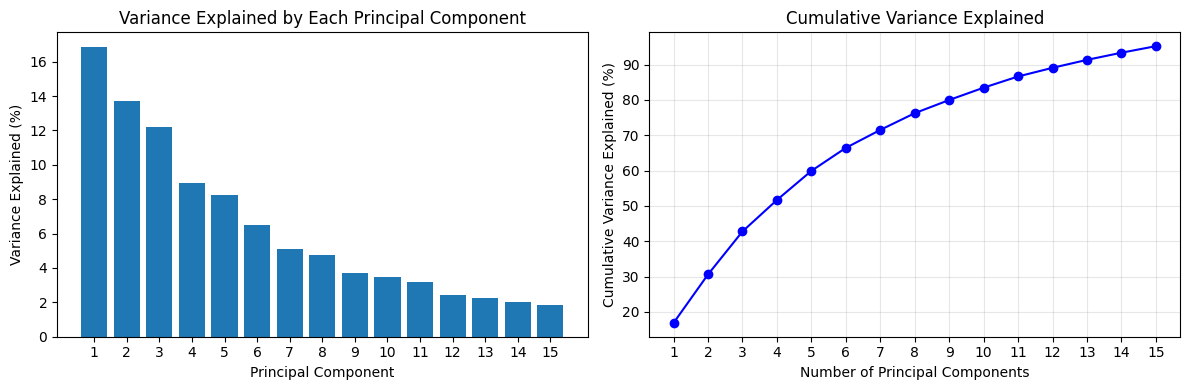


Total variance captured by 15 components: 95.24%


In [10]:
# Plot variance explained by each component
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Individual variance explained
ax1.bar(range(1, n_components + 1), pca.explained_variance_ratio_ * 100)
ax1.set_xlabel("Principal Component")
ax1.set_ylabel("Variance Explained (%)")
ax1.set_title("Variance Explained by Each Principal Component")
ax1.set_xticks(range(1, n_components + 1))

# Cumulative variance explained
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
ax2.plot(range(1, n_components + 1), cumulative_variance * 100, "bo-")
ax2.set_xlabel("Number of Principal Components")
ax2.set_ylabel("Cumulative Variance Explained (%)")
ax2.set_title("Cumulative Variance Explained")
ax2.set_xticks(range(1, n_components + 1))
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(
    f"\nTotal variance captured by {n_components} components: {cumulative_variance[-1] * 100:.2f}%"
)

## Summary and Usage

The PCA model has been computed and saved. Here's what you can do:

### Changing the Number of Components

To compute a different number of PCA components:
1. Change the `n_components` variable in cell 2
2. Re-run all cells from cell 2 onwards

### Using the PCA Model

The exported JSON file contains:
- `explained_variance_ratio`: The proportion of variance explained by each component
- `eigenvalues`: The eigenvalues (variance) for each component  
- `components`: The principal component vectors (each is a flattened array of shape deformations)

### Reconstructing Shapes

To reconstruct a shape from PCA weights:
```python
# weights = [w1, w2, ..., wn] where n = n_components
reconstructed_shape = mean_shape + sum(weights[i] * pca.components_[i] for i in range(n_components))
reconstructed_points = reconstructed_shape.reshape(-1, 3)
```